In [1]:
import pandas as pd
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [81]:
dataset = pd.read_csv('df_youtube.csv')
dataset

,sentiment,text
0,positive,Qahramonlarga ming rahmat Kun uz sizlarni otan...
1,positive,Қахрамон йигитларга шарафлар бўлсин доимо омад...
2,positive,Илохим олий укув юртларга укишга кириб кетсинл...
3,positive,Оллохни каромати чексиз!!! Оллохга шкур. Оллох...
4,positive,"Кизалок сог булсин, амин."
...,...,...
1047,negative,Bu jahannamda yongur itdan tarqagan lar Allo...
1048,negative,Нима биза куйми биза уриб улдириб узини дераза...
1049,negative,Халиям мактабларда чириб кеттган парта ...
1050,negative,Курисин йуколсин вадалари Билан


In [82]:
dataset = dataset.sample(frac=1)

In [83]:
train = dataset.iloc[:990]
validation = dataset.iloc[990:]

In [84]:
print(f"Train dataset shape {train.shape}")
print(f"Validation dataset shape {validation.shape}")

Train dataset shape (990, 2)
Validation dataset shape (62, 2)


In [76]:
train

,sentiment,text
750,negative,Эх мусулмон узбекистонлик уйгонилар бу шавкат ...
184,negative,Каримов чегараларни ланг очиб куймаган..хар ка...
673,neutral,Болам ўқиб нима қиласан мин сўм беринг акажонл...
770,positive,Тинчлик ва хавфсизликни таъминлаш мақсадида да...
88,positive,Соломат булинглар йигитлар
...,...,...
424,positive,Нуткка гап йук бобур акмалов
985,negative,Хар йили 4 5 та Камбагал Оилаларни Боллари Улд...
401,negative,Ха мустакл болдик бутун дунёга кул болик
611,positive,Cool


In [85]:
# checking nan values 
print("\t\t\tTrain dataset")
print(train.isna().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.isna().sum())

			Train dataset
sentiment    0
text         0
dtype: int64
****************************************
			Validation dataset
sentiment    0
text         0
dtype: int64


In [87]:
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [89]:
train['text'] = train['text'].apply(lambda x: remove_emojis(x))
train['text'] = train['text'].apply(lambda x: remove_urls(x))

validation['text'] = validation['text'].apply(lambda x: remove_emojis(x))
validation['text'] = validation['text'].apply(lambda x: remove_urls(x))

/var/folders/g1/4mss6fjs2klg0xx3r98rcdr80000gn/T/ipykernel_29628/4120044860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].apply(lambda x: remove_emojis(x))
/var/folders/g1/4mss6fjs2klg0xx3r98rcdr80000gn/T/ipykernel_29628/4120044860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].apply(lambda x: remove_urls(x))
/var/folders/g1/4mss6fjs2klg0xx3r98rcdr80000gn/T/ipykernel_29628/4120044860.py:4: SettingWithCopyWarning: 
A value is trying to be

In [93]:
train['text_lens']=train['text'].apply(lambda x: len(x))
validation['text_lens']=validation['text'].apply(lambda x: len(x))

/var/folders/g1/4mss6fjs2klg0xx3r98rcdr80000gn/T/ipykernel_29628/2981926920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text_lens']=train['text'].apply(lambda x: len(x))
/var/folders/g1/4mss6fjs2klg0xx3r98rcdr80000gn/T/ipykernel_29628/2981926920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['text_lens']=validation['text'].apply(lambda x: len(x))


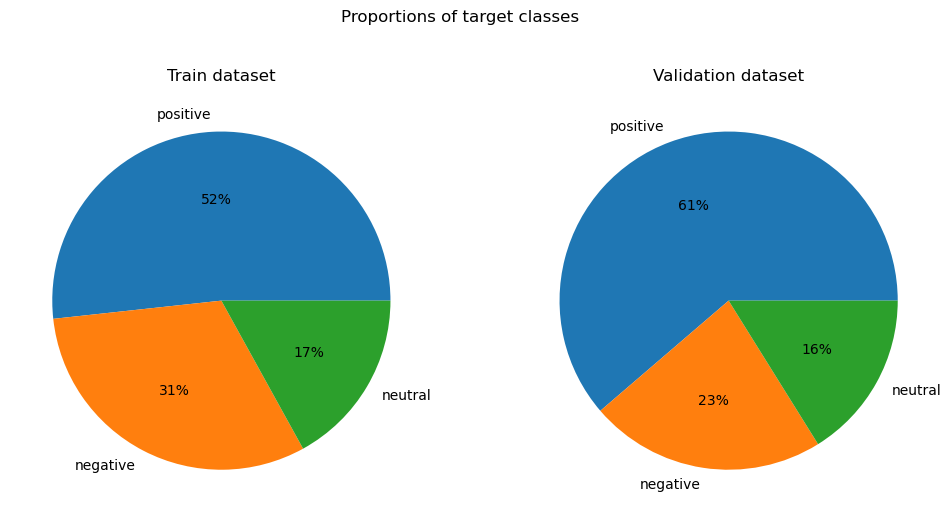

In [91]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].pie(train['sentiment'].value_counts(),labels=train['sentiment'].value_counts().index,autopct='%.f%%')
ax[1].pie(validation['sentiment'].value_counts(),labels=validation['sentiment'].value_counts().index,autopct='%.f%%')

fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

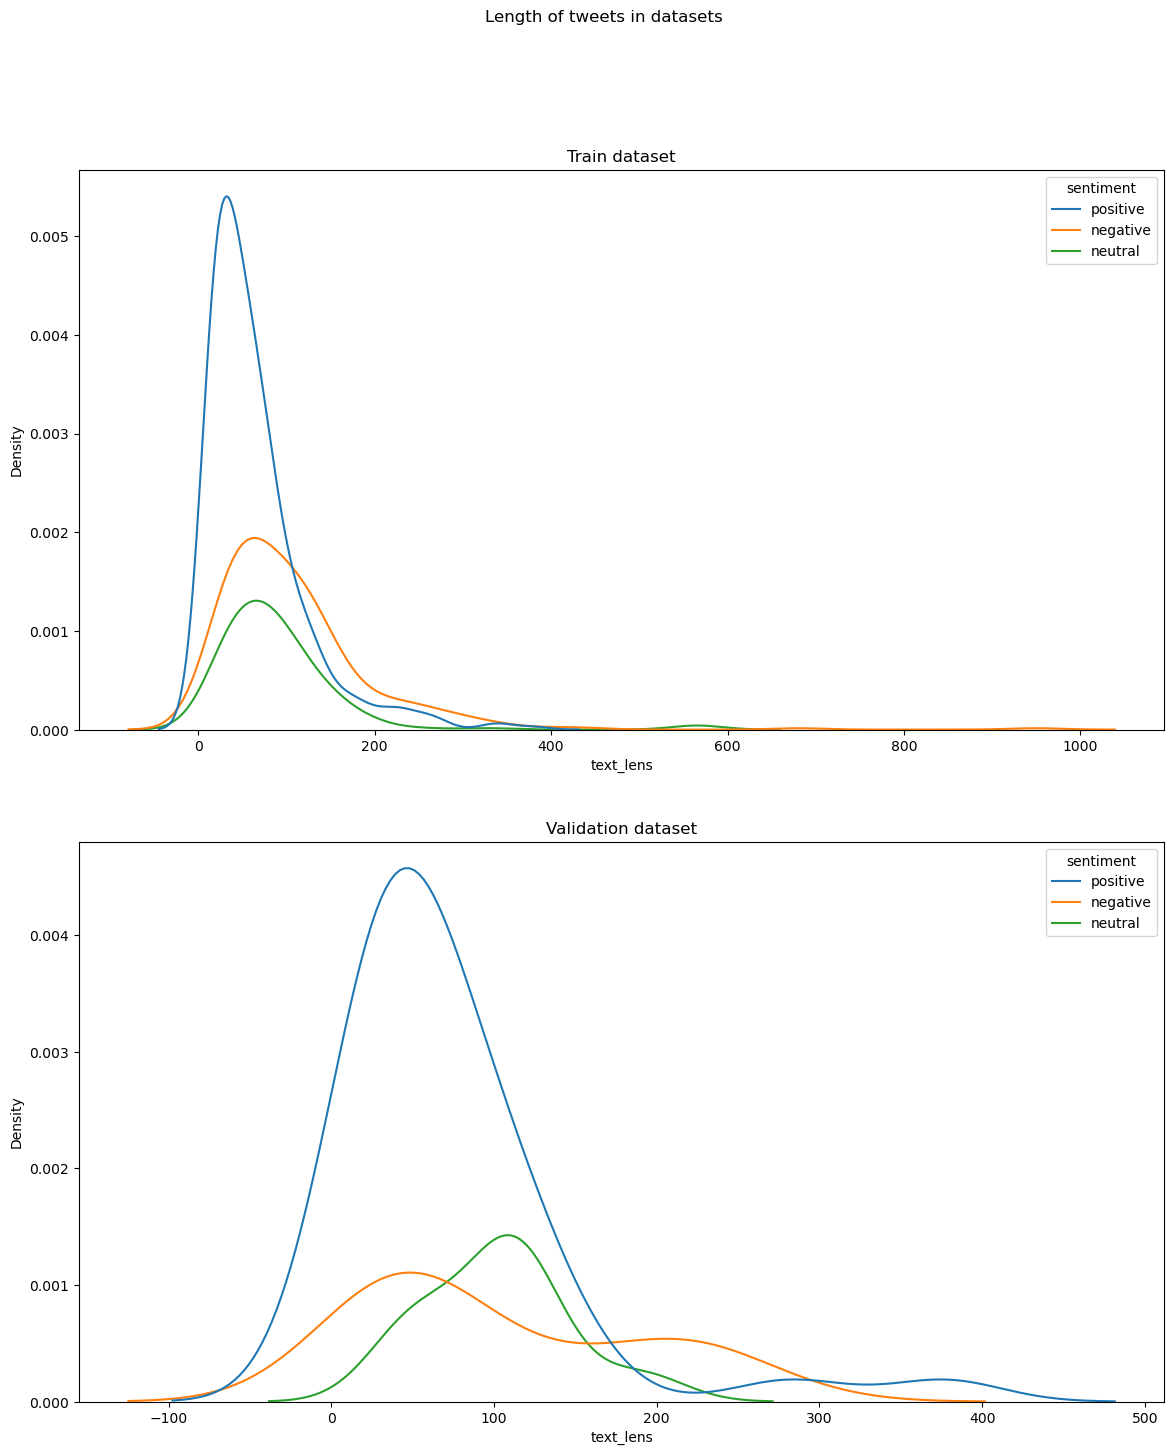

In [95]:
fig ,ax = plt.subplots(2,1,figsize=(14,16))

sns.kdeplot(data=train,x='text_lens',hue='sentiment',ax=ax[0])
sns.kdeplot(data=validation,x='text_lens',hue='sentiment',ax=ax[1])

fig.suptitle("Length of tweets in datasets")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

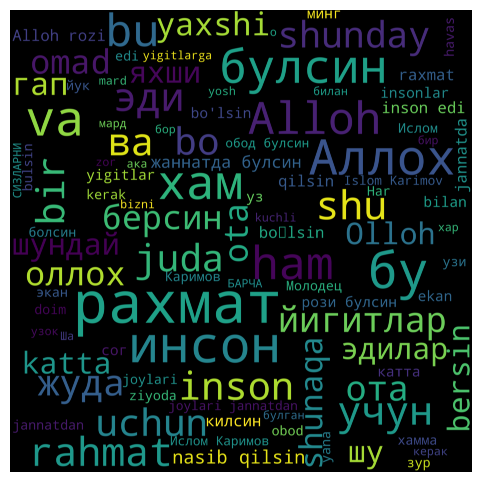

In [96]:
word_cloud_text = ''.join(train[train["sentiment"]=="positive"].text)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

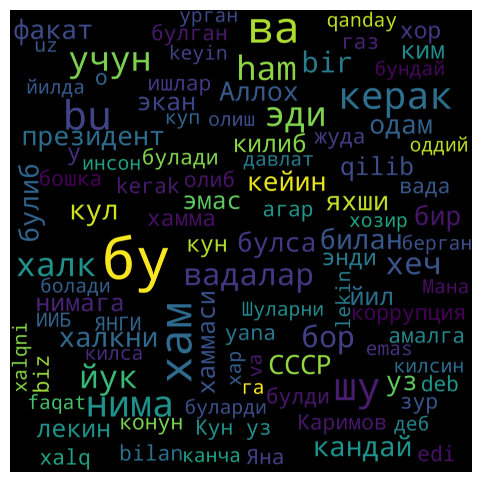

In [97]:
word_cloud_text_negative = ''.join(train[train["sentiment"]=="negative"].text)
wordcloud_negative = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text_negative)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.show()

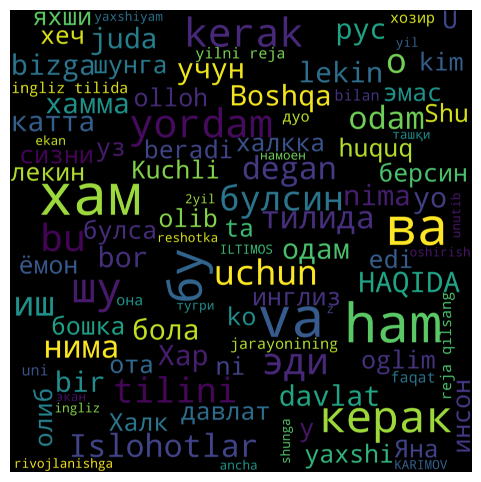

In [98]:
word_cloud_text = ''.join(train[train["sentiment"]=="neutral"].text)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

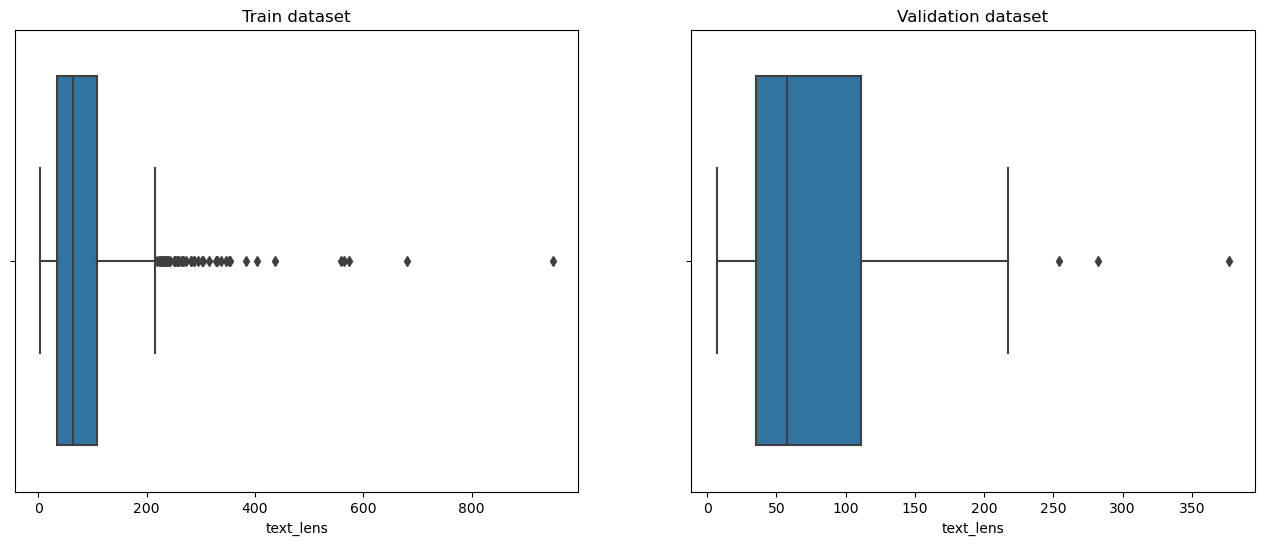

In [99]:
fig , ax = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=train,x='text_lens',ax=ax[0])
sns.boxplot(data=validation,x='text_lens',ax=ax[1])

ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

In [3]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [100]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train = remove_outlier(train,'text_lens')

<b><code>Yuqoridagi 'en_core_web_lg' modeli o'zbek tilida alternativi yo'q.</code></b>

<b><code>Creating a high-quality language model like en_core_web_sm for Uzbek requires significant resources, including expertise in NLP, access to sufficient training data, and computational power. It is a complex task that often involves a team of researchers and linguists.
If you're interested in creating an Uzbek language model, you may need to explore existing resources, such as publicly available corpora or initiatives related to Uzbek language processing, which can provide a foundation for building such a model.</code></b>

In [101]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

train['preprocessed_text']=train['text'].apply(lambda x: preprocess(x))
validation['preprocessed_text']=validation['text'].apply(lambda x: preprocess(x))

NameError: name 'nlp' is not defined